<a href="https://colab.research.google.com/github/anupam-codespace/Machine-Learning-Assignments/blob/main/Assignment_1_Digit_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Assignment-01**
Recognize a digit using TensorFlow/PyTorch.

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

01. **import tensorflow as tf** – Main deep learning framework.
02. **mnist** – Loads handwritten digit dataset.
03. **Sequential** – Builds models layer-by-layer.
04. **Conv2D** – Extracts image features.
05. **MaxPooling2D** – Reduces size & overfitting.
06. **Flatten** – Converts 2D to 1D.
07. **Dense** – Fully connected layer for output.
08. **Dropout** – Prevents overfitting.
09. **to_categorical** – Converts labels to one-hot format.
10. **plt** – For plotting graphs/visualizations.

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Loads the ***MNIST dataset*** from **Keras**.

Splits it into training data *(x_train, y_train)* and testing data *(x_test, y_test)*.

In [ ]:
x_train = x_train / 255.0
x_test = x_test / 255.0

Purpose: Normalizes ***pixel values from 0–255 to 0–1***.

Why: Makes training faster, improves accuracy, and helps the model converge smoothly.

In [ ]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

01. Reshapes images to **(number_of_samples, height, width, channels)**format.
02. -1 automatically adjusts the number of samples.
03. 1 is the channel for grayscale images (*RGB would have 3*).
04. Needed so CNN layers know the correct image shape.


In [ ]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

01. **y_train = to_categorical(y_train, 10)**
Converts training labels into one-hot vectors of length 10 (digits 0–9).
02. **y_test = to_categorical(y_test, 10)**
Does the same for test labels, preparing them for multi-class classification.

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


01. **Model = Sequential()** – Creates a simple sequential model (layers stacked in order).
02. **Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1))**– First convolution layer with 32 filters, detects image features; relu adds non-linearity; input is 28×28 grayscale.
03. **MaxPooling2D((2, 2))**– Reduces image size by half to speed up training.
04. **Conv2D(64, (3, 3), activation='relu')** – Second convolution layer with 64 filters for deeper feature extraction.
05.**MaxPooling2D((2, 2))**– Again reduces size to focus on key features.
06. **Flatten()** – Turns 2D feature maps into a 1D vector for dense layers.
07. **Dense(128, activation='relu')** – Fully connected layer with 128 neurons for learning complex patterns.
08. **Dropout(0.3)** – Drops 30% neurons randomly to prevent overfitting.
09. **Dense(10, activation='softmax')**– Output layer with 10 neurons (digits 0–9), softmax for probability scores.

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

01. **optimizer='adam'** → Uses Adam optimizer for fast and efficient training.

02. **loss='categorical_crossentropy'** → Measures error for multi-class classification.

03. **metrics=['accuracy']** → Tracks accuracy during training/testing.

In [ ]:
history = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 48s 50ms/step - accuracy: 0.8714 - loss: 0.4101 - val_accuracy: 0.9840 - val_loss: 0.0499
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 81s 48ms/step - accuracy: 0.9787 - loss: 0.0665 - val_accuracy: 0.9880 - val_loss: 0.0345
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 82s 48ms/step - accuracy: 0.9851 - loss: 0.0465 - val_accuracy: 0.9907 - val_loss: 0.0286
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 47s 51ms/step - accuracy: 0.9886 - loss: 0.0395 - val_accuracy: 0.9903 - val_loss: 0.0302
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 79s 48ms/step - accuracy: 0.9911 - loss: 0.0290 - val_accuracy: 0.9925 - val_loss: 0.0238


In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9906 - loss: 0.0298
Test Accuracy: 0.9925


01. *test_loss, test_acc = model.evaluate(x_test, y_test)* – Tests the trained model on unseen data to get the loss and accuracy.

02. *print(f"Test Accuracy: {test_acc:.4f}")* – Displays the test accuracy, formatted to 4 decimal places.

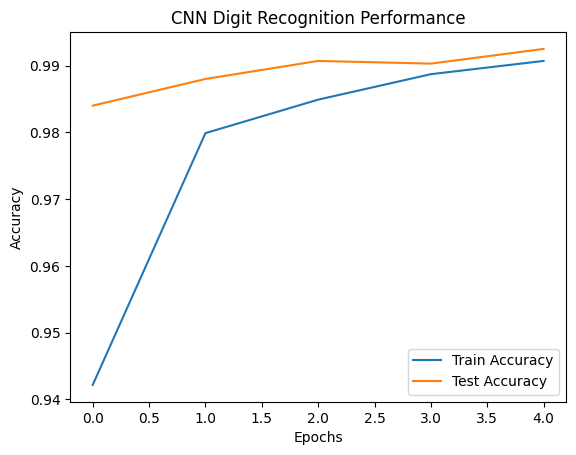

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('CNN Digit Recognition Performance')
plt.show()

01. **plt.plot(...**) – Plots training (accuracy) and testing (val_accuracy) performance over epochs.

02. **plt.xlabel() / plt.ylabel()** – Labels the X-axis (epochs) and Y-axis (accuracy).

03. **plt.legend()** – Shows labels for each line in the plot.

04. **plt.title()** – Sets the graph title.

05. **plt.show()** – Displays the plot.

To read the **detailed documentation**: [click here🤝](https://docs.google.com/document/d/1yn_iTuoqq4Tn6nX2r2aioUAiaiKAdZJE_nYoRpIUrBw/edit?usp=sharing)